# Multihead-attention

# Importing required libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [3]:
seq_length = 4                                 # "My name is Baktho", 4 letters o sequence length is 4
batch_size = 1                                 # just a single sentence so one batch
input_dim = 512                                # each vector will be of 512 x 1 dimensions
d_model = 512                                  # output of the attention unit
x = torch.randn( ( batch_size, seq_length, input_dim  ) )

In [4]:
x.size()

torch.Size([1, 4, 512])

In [5]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)  # to concatenate query vec,key vec and Value vector

In [6]:
qkv = qkv_layer(x)                             # pass through this layer to generate the qkv vector

In [7]:
qkv.shape                                      # 1 sentence, 4 sequence length and q,k,v vecs of each 512 dims so a total of 1536 dims

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

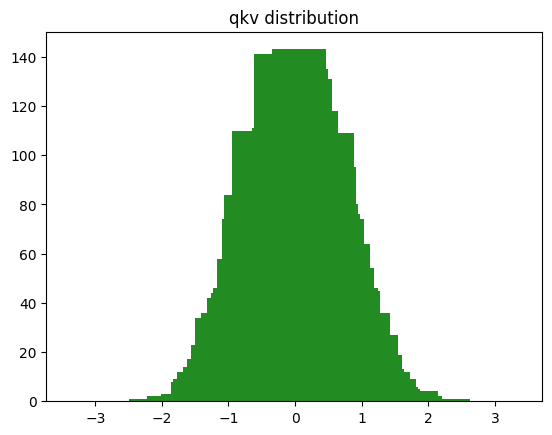

In [8]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 200, min = -3, max = 3)
x_val = np.arange(-1,1,0.01)*3
plt.bar(x_val,y_val,align = "center", color = ['forestgreen']) # will be a random normal dist
plt.title('qkv distribution')

In [9]:
num_heads = 8                    # number of attention units/heads
head_dim = d_model//num_heads    # each will be 512/8 = 64
 # breakdown last dimension by 8 (cuz 8 attention heads) and 3*head_dims cuz q,k,v(=3)
qkv = qkv.reshape(batch_size,seq_length,num_heads,3 * head_dim)

In [10]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [11]:
qkv = qkv.permute(0,2,1,3)        # switching 2nd and 3rd dims so itll be easier to perform parellel operations on last two dimensions
qkv.shape

torch.Size([1, 8, 4, 192])

In [12]:
q,k,v = qkv.chunk(3,dim=-1)       # breaking down the tensor into q,k,v by the last dim, thus dim=-1
q.shape,k.shape,v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

# Self attention for multiple heads

<h4>self attention ( for single head ) </h4>
 =
<br> <h3> softmax((Q.Kᵀ ÷ √dk) + M)V </h3>




In [32]:
d_k = q.shape[-1]

'''
since these are 4 dimensional tensors u cant use '.T' we have to specifiy along what dimensions
do we want the tensor to be transposed, here -2,-1
(This is why we used permute funcion to switch 2nd and 3rd column - seq_length and head_dim - previously)
'''

scaled = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)   # scaling to reduce variance

# basically a 4x4 matrix - seq_length x seq_length
scaled.shape

torch.Size([1, 8, 4, 4])

In [14]:
k.T.shape                                      # small example for why we didnt use .T

<ipython-input-14-879c2705464e>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [15]:
k.transpose(-2,-1).shape

torch.Size([1, 8, 64, 4])

In [16]:
mask = torch.full(scaled.size(), float('-inf')) # triangular matrix
mask = torch.triu(mask,diagonal = 1)
mask[0][1]                                      # this is to make sure the decoder doesnt cheat by using future words to predict present words,unnecessary for encoders

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [17]:
scaled+=mask

In [18]:
attention = F.softmax(scaled,dim=-1)             # dim = -1 cuz the tensors will be in the last dim

In [19]:
attention.shape

torch.Size([1, 8, 4, 4])

In [40]:
attention[0][0]                                 # every row adds up to 1, why? Probabilitieess
# this 4x4 attention matrix tells us how much a word is related to another in the sentence

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4716, 0.5284, 0.0000, 0.0000],
        [0.3850, 0.3798, 0.2353, 0.0000],
        [0.1707, 0.3634, 0.1008, 0.3651]], grad_fn=<SelectBackward0>)

In [41]:
values = torch.matmul(attention, v)
values.shape                                    # this value vector will be comparatively much more context aware
# we end up with a 64 dim vector for every sequence for every head for every batch

torch.Size([1, 8, 4, 64])

# Function

In [42]:
# Just combine all the above code and make it into a function
# this will be a single self attention head

def scaled_dot_product(q,k,v, mask = None):     # mask = none for encoders, mask = mask for decoders
  d_k = q.size()[-1]
  mm = torch.matmul(q,k.transpose(-2,-1))
  scaled = mm/math.sqrt(d_k)
  if mask is not None:
    scaled = scaled+mask
  attention = F.softmax(scaled, dim = -1)
  output = torch.matmul(attention,v)
  return output, attention

In [43]:
values, attention = scaled_dot_product(q,k,v, mask=mask)
print("Q\n",q,"\nK\n",k,"\nV\n",v)
print("Values\n",values,"\nAttention\n",attention)

Q
 tensor([[[[-0.1301,  0.0857,  0.3779,  ..., -0.0284, -0.0527, -0.6084],
          [-0.5142,  0.5295, -0.0208,  ...,  0.3907, -0.8274,  0.0957],
          [ 0.0505,  0.8751,  0.1564,  ..., -0.7117, -0.4734, -0.1008],
          [-0.1558,  0.6907, -0.0031,  ...,  0.3236,  0.3047, -0.0852]],

         [[ 0.1465, -0.3487,  0.4665,  ..., -0.6269,  1.0690,  0.0246],
          [-0.3476, -1.2640,  0.6492,  ..., -0.2441, -0.9075, -0.2408],
          [-0.1760,  0.5984,  0.9004,  ..., -0.5723, -0.9885,  0.4817],
          [-0.5915,  0.7103,  0.0720,  ...,  0.5368, -0.9781,  0.5937]],

         [[-0.5599,  0.0911, -0.2061,  ..., -0.0687, -0.8808, -1.2963],
          [-0.1329, -0.9496,  0.3451,  ..., -0.9996,  0.9164,  0.5029],
          [-0.1827,  0.0301, -0.2805,  ..., -0.7398,  0.4927,  1.1685],
          [-0.2519, -0.0885, -0.3672,  ..., -0.6303,  1.0358,  0.0494]],

         ...,

         [[ 0.3826, -0.1644, -0.4895,  ...,  0.2282, -0.6658,  0.4612],
          [-0.6635,  1.7157, -0.1362,  .

In [44]:
attention.shape

torch.Size([1, 8, 4, 4])

In [45]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4716, 0.5284, 0.0000, 0.0000],
        [0.3850, 0.3798, 0.2353, 0.0000],
        [0.1707, 0.3634, 0.1008, 0.3651]], grad_fn=<SelectBackward0>)

In [46]:
values.size()

torch.Size([1, 8, 4, 64])

In [47]:
values = values.reshape(batch_size,seq_length,num_heads * head_dim)
values.size()

RuntimeError: shape '[30, 5, 512]' is invalid for input of size 2048

In [ ]:
linear_layer = nn.Linear(d_model,d_model)
out = linear_layer(values)
out

In [48]:
batch_size,seq_length,num_heads,3 * head_dim

(30, 5, 8, 192)

# Final Function

In [49]:
# now we combine all the code create a multiheaded attention class for, well multihead attention mechanism
# simply put multihead attention = multiple single headed attention whose outputs are concatenated together

def scaled_dot_product(q,k,v, mask = None):
  d_k = q.size()[-1]
  mm = torch.matmul(q,k.transpose(-2,-1))
  scaled = mm/math.sqrt(d_k)
  if mask is not None:
    scaled = scaled+mask
  attention = F.softmax(scaled, dim = -1)
  output = torch.matmul(attention,v)
  return output, attention

class MultiheadAttention(nn.Module):
  def __init__(self,input_dim,d_model,num_heads):
    super().__init__()
    self.input_dim = input_dim
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(input_dim,3*d_model)
    self.linear_layer = nn.Linear(d_model,d_model)

  def forward(self,x,mask=None):

    batch_size,sequence_length,input_dim=x.size()
    print(f"x.size():{x.size()}")

    qkv = self.qkv_layer(x)
    print(f"qkv.size():{qkv.size()}")

    qkv = qkv.reshape(batch_size,seq_length,self.num_heads,3 * self.head_dim)
    print(f"qkv.size():{qkv.size()}")

    qkv = qkv.permute(0,2,1,3)
    print(f"qkv.size():{qkv.size()}")

    q,k,v = qkv.chunk(3,dim=-1)
    print(f"q.size():{q.size()}, \nk.size():{k.size()}, \nv.size():{v.size()}")

    values, attention = scaled_dot_product(q,k,v, mask=mask)
    print(f"values.size():{values.size()}, \nattention.size():{attention.size()}")

    values = values.reshape(batch_size,seq_length,self.num_heads * self.head_dim)
    print(f"values.size():{values.size()}")

    out = self.linear_layer(values)
    print(f"out.size():{out.size()}")

    return out

In [50]:
# sample
seq_length = 5
batch_size = 30
input_dim = 1024
d_model = 512
num_heads = 8

x = torch.randn( ( batch_size, seq_length, input_dim  ) )

model = MultiheadAttention( input_dim,d_model,num_heads )
out = model.forward(x)

x.size():torch.Size([30, 5, 1024])
qkv.size():torch.Size([30, 5, 1536])
qkv.size():torch.Size([30, 5, 8, 192])
qkv.size():torch.Size([30, 8, 5, 192])
q.size():torch.Size([30, 8, 5, 64]), 
k.size():torch.Size([30, 8, 5, 64]), 
v.size():torch.Size([30, 8, 5, 64])
values.size():torch.Size([30, 8, 5, 64]), 
attention.size():torch.Size([30, 8, 5, 5])
values.size():torch.Size([30, 5, 512])
out.size():torch.Size([30, 5, 512])
